In [1]:
#### DO NOT RUN THIS CODE IN THE NOTEBOOK - copy paste into terminal in the HOME directory!

# git clone https://github.com/tensorflow/models.git

In [2]:
# !pip install s3fs -q
# !pip install tensorflow_hub -q
# !pip install tensorflow_datasets -q
# !pip install pycocotools -q
# !pip install gin-config -q
# !pip install immutabledict -q
# !pip install sentencepiece -q
# !pip install transformers -q
# !pip install evaluate -q
# !pip install sacrebleu -q
# !pip install bert_score -q
# !pip install sentence-transformers -q
# !pip install keras-nlp -q
# !pip install tensorflow-model-optimization -q
# !pip install pyarrow fastparquet -q
# !pip install -r official/projects/movinet/requirements.txt -q

In [3]:
import configparser

config = configparser.ConfigParser()
config.read('/home/ec2-user/.aws/credentials')

['/home/ec2-user/.aws/credentials']

In [4]:
# AWS credentials and S3 settings
aws_access_key_id = config["default"]['aws_access_key_id']
aws_secret_access_key = config["default"]['aws_secret_access_key']
bucket_name = 'asl-capstone'
s3_URI = 's3://asl-capstone/'

In [5]:
import s3fs
fs = s3fs.S3FileSystem(key=aws_access_key_id, secret=aws_secret_access_key)

import boto3
s3 = boto3.client('s3',aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key,
                  region_name = 'us-west-2')


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from tqdm import tqdm

# import evaluate
# import tensorflow_model_optimization as tfmot

from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(2)
tf.keras.backend.clear_session()

2023-11-29 23:33:26.776857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 23:33:27.490312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
# !export XLA_PYTHON_CLIENT_PREALLOCATE=false
# !export XLA_FLAGS="--xla_gpu_strict_conv_algorithm_picker=false --xla_gpu_force_compilation_parallelism=1"

In [8]:
# Load model directly
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, TFT5ForConditionalGeneration #, TFT5EncoderModel
# from transformers.modeling_tf_outputs import TFBaseModelOutputWithPastAndCrossAttentions

# with tf.device("/GPU:0"):
tokenizer = AutoTokenizer.from_pretrained("t5-large")
model = TFAutoModelForSeq2SeqLM.from_pretrained("t5-large")
    # encoder_model = T5EncoderModel.from_pretrained("google/t5-v1_1-large")

model.trainable = True

# tokenizer = AutoTokenizer.from_pretrained("t5-large")
# model = TFT5ForConditionalGeneration.from_pretrained("t5-large")
# encoder_model = T5EncoderModel.from_pretrained("t5-large")

# ENCODER_DIM = 768
ENCODER_DIM = 1024


model.summary()

/opt/tensorflow/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
2023-11-29 23:33:31.457332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  32899072  
                                                                 
 encoder (TFT5MainLayer)     multiple                  334939648 
                                                                 
 decoder (TFT5MainLayer)     multiple                  435627520 
                                                                 
Total params: 737668096 (2.75 GB)
Trainable params: 737668096 (2.75 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.trainable = True

# for i in range(3):
#     model.encoder.block[-(i+3)].trainable = False

# for i in range(10):
#     model.encoder.block[-(i+1)].trainable = False

model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  32899072  
                                                                 
 encoder (TFT5MainLayer)     multiple                  334939648 
                                                                 
 decoder (TFT5MainLayer)     multiple                  435627520 
                                                                 
Total params: 737668096 (2.75 GB)
Trainable params: 737668096 (2.75 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
val_files = pd.read_csv("s3://asl-capstone/how2sign/i3d.val.how2sign.tsv", 
                          sep='\t', usecols=['signs_file', 'translation'])

test_files = pd.read_csv("s3://asl-capstone/how2sign/i3d.test.how2sign.tsv", 
                          sep='\t', usecols=['signs_file', 'translation'])

# train_files = pd.read_csv("s3://asl-capstone/how2sign/i3d.train.how2sign.tsv", 
#                           sep='\t', usecols=['signs_file', 'translation'])

In [11]:
video_files = pd.concat([val_files, test_files], axis=0) #train_files
video_files['signs_file'] = video_files.signs_file.str.replace('/path_to_features/how2sign/i3d_features/','s3://asl-capstone/how2sign/')
video_files['signs_file'] = video_files.signs_file.str.replace('/home/usuaris/imatge/ltarres/wicv2023/how2sign/i3d_features/','s3://asl-capstone/how2sign/')
video_files['signs_file'] = video_files.signs_file.str.replace('/train/','/train_kaggle/')
video_files = video_files.rename(columns={'signs_file':'i3d_path', 'translation':'caption'})
video_files = video_files.drop_duplicates().reset_index(drop=True)


video_files.head()

,i3d_path,caption
0,s3://asl-capstone/how2sign/val/-d5dN54tH2E_0-1...,We're going to work on a arm drill that will h...
1,s3://asl-capstone/how2sign/val/-d5dN54tH2E_1-1...,I call it painting the wall.
2,s3://asl-capstone/how2sign/val/-d5dN54tH2E_10-...,So we're going to go up and down; let's switch...
3,s3://asl-capstone/how2sign/val/-d5dN54tH2E_11-...,And just let those fingers relax.
4,s3://asl-capstone/how2sign/val/-d5dN54tH2E_12-...,Now together you're going to go opposite.


In [12]:
video_files['caption_cleaned'] = video_files.caption.str.lower().str.replace(r'\[*\]', ' ').str.replace('\n',' ').str.replace('  ',' ').str.replace('...','. ').str.replace('..','.').str.replace('♪', '').str.replace('♫','').str.replace('#','').str.strip(' ')

video_files = video_files[video_files['caption_cleaned']!='']
video_files = video_files[video_files['caption_cleaned']!='.']

print(video_files.shape)
video_files.head()

(4041, 3)


,i3d_path,caption,caption_cleaned
0,s3://asl-capstone/how2sign/val/-d5dN54tH2E_0-1...,We're going to work on a arm drill that will h...,we're going to work on a arm drill that will h...
1,s3://asl-capstone/how2sign/val/-d5dN54tH2E_1-1...,I call it painting the wall.,i call it painting the wall.
2,s3://asl-capstone/how2sign/val/-d5dN54tH2E_10-...,So we're going to go up and down; let's switch...,so we're going to go up and down; let's switch...
3,s3://asl-capstone/how2sign/val/-d5dN54tH2E_11-...,And just let those fingers relax.,and just let those fingers relax.
4,s3://asl-capstone/how2sign/val/-d5dN54tH2E_12-...,Now together you're going to go opposite.,now together you're going to go opposite.


In [13]:
s3_val_files = fs.ls('s3://asl-capstone/how2sign/val/')
s3_val_files = ['s3://' + file for file in s3_val_files]

s3_test_files = fs.ls('s3://asl-capstone/how2sign/test/')
s3_test_files = ['s3://' + file for file in s3_test_files]

s3_train_files = fs.ls('s3://asl-capstone/how2sign/train_kaggle/')
s3_train_files = ['s3://' + file for file in s3_train_files]


s3_files = s3_val_files + s3_test_files + s3_train_files
print(s3_files[0])
len(s3_files)

s3://asl-capstone/how2sign/val/-d5dN54tH2E_0-1-rgb_front.npy


30920

In [14]:
video_files = video_files[video_files['i3d_path'].isin(s3_files)]
print(video_files.shape)
video_files.head()

(4041, 3)


,i3d_path,caption,caption_cleaned
0,s3://asl-capstone/how2sign/val/-d5dN54tH2E_0-1...,We're going to work on a arm drill that will h...,we're going to work on a arm drill that will h...
1,s3://asl-capstone/how2sign/val/-d5dN54tH2E_1-1...,I call it painting the wall.,i call it painting the wall.
2,s3://asl-capstone/how2sign/val/-d5dN54tH2E_10-...,So we're going to go up and down; let's switch...,so we're going to go up and down; let's switch...
3,s3://asl-capstone/how2sign/val/-d5dN54tH2E_11-...,And just let those fingers relax.,and just let those fingers relax.
4,s3://asl-capstone/how2sign/val/-d5dN54tH2E_12-...,Now together you're going to go opposite.,now together you're going to go opposite.


<Axes: >

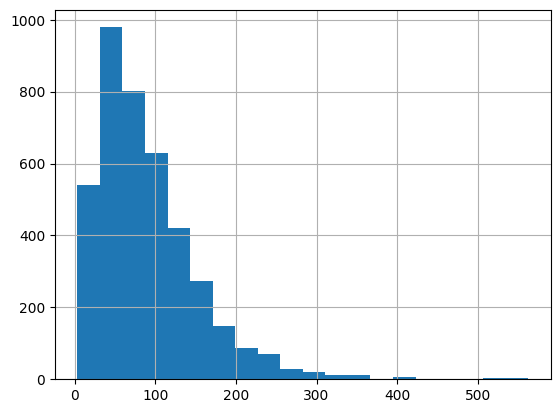

In [15]:
# video_files[(video_files['caption_cleaned'].str.len() > 40) & (video_files['caption_cleaned'].str.len() < 60)].caption_cleaned.unique()

video_files['caption_cleaned'].str.len().hist(bins=20)

In [16]:
### Start at training mini model to convert from to correct shape for T5
# # Loss function: CosineSimilarity.
# # Minimize for cosine sim between avg label emb and avg vid emb (after flattening)?
# vid_labels = tokenizer(video_files['caption_cleaned'].to_list(), return_tensors="tf", padding=True)
# label_embeds = model.encoder.embed_tokens(vid_labels.input_ids)
# label_embeds_avg = tf.math.reduce_mean(label_embeds, axis=1)

In [17]:
train_files, test_files = train_test_split(video_files, train_size=0.9)
test_files, val_files = train_test_split(test_files, train_size=0.8)

# train_files = train_files.sample(50)
# test_files = test_files.sample(50)

print(train_files.shape)
print(test_files.shape)
print(val_files.shape)

(3636, 3)
(405, 3)


In [18]:
def data_generator(file_paths_df, n_frames=512):
    for _, row in file_paths_df.iterrows():
        with fs.open(row['i3d_path'], 'rb') as f:
            vid_embedding = np.load(f) #.astype(np.float16)

        
        if vid_embedding.shape[0] < n_frames:
            # for shorter frame lengths, pad with zeros
            padding = tf.zeros((tf.constant(n_frames) - vid_embedding.shape[0], 
                                vid_embedding.shape[1]))
            
            attention_mask = tf.concat([tf.ones(vid_embedding.shape[0]), 
                                        tf.zeros(tf.constant(n_frames) - vid_embedding.shape[0])], 
                                       axis=0)
            
            vid_embedding = tf.concat([vid_embedding, padding], axis=0)
            
        elif vid_embedding.shape[0] > n_frames:
            # for longer frame lengths, interpolate
            vid_embedding = vid_embedding[:n_frames]
            attention_mask = tf.ones(vid_embedding.shape[0])
        
        else:
            # for exactly right size, just output attention_mask
            attention_mask = tf.ones(vid_embedding.shape[0])
        
        
        label = tokenizer(row['caption_cleaned'], return_tensors="tf", 
                           padding='max_length', max_length=128, truncation=True).input_ids[0]
        # label = row['caption']
        
        yield {'inputs_embeds':vid_embedding, #'input_ids':None, 'training':True,
               'attention_mask':attention_mask, 'labels':label}


In [19]:
# TRY DATACOLLATOR or IterableDataset

# from datasets import IterableDataset
# train_dataset = IterableDataset.from_generator(lambda: data_generator(train_files[:32], conv, flatten, n_frames=256))

In [20]:
# list(train_dataset.take(1))

In [21]:
# training_args = transformers.Seq2SeqTrainingArguments()

In [22]:
# Create TensorFlow Dataset for model input. 
N_FRAMES = 256

train_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(train_files, n_frames=N_FRAMES),
    output_signature=({'inputs_embeds':tf.TensorSpec(shape=(N_FRAMES, ENCODER_DIM), dtype=tf.float32),
                       'attention_mask':tf.TensorSpec(shape=(N_FRAMES), dtype=tf.float32), 
                       'labels':tf.TensorSpec(shape=(128), dtype=tf.int32)}
                       ))

test_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(test_files, n_frames=N_FRAMES),
    output_signature=({'inputs_embeds':tf.TensorSpec(shape=(N_FRAMES, ENCODER_DIM), dtype=tf.float32),
                       'attention_mask':tf.TensorSpec(shape=(N_FRAMES), dtype=tf.float32), 
                       'labels':tf.TensorSpec(shape=(128), dtype=tf.int32)}
                       ))

eval_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(val_files, conv, flatten, n_frames=N_FRAMES),
    output_signature=({'inputs_embeds':tf.TensorSpec(shape=(N_FRAMES, ENCODER_DIM), dtype=tf.float32),
                       'attention_mask':tf.TensorSpec(shape=(N_FRAMES), dtype=tf.float32), 
                       'labels':tf.TensorSpec(shape=(64), dtype=tf.int32)}
                       ))

In [23]:
from transformers.keras_callbacks import KerasMetricCallback
from sentence_transformers import SentenceTransformer, util
import evaluate

bleu = evaluate.load("sacrebleu")
bertscore = evaluate.load("bertscore",device="cpu")
st_sim = SentenceTransformer('all-mpnet-base-v2',device="cpu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    if isinstance(preds, tuple):
        preds = preds[0]

    # Decode tokens to words
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Create SentenceTransformer embeddings from words
    st_preds = st_sim.encode(decoded_preds)
    st_labels = st_sim.encode(decoded_labels)

    # Calculate cosine similarity
    cos_sim = []
    for p, l in zip(st_preds, st_labels):
        cos_sim.append(float(util.cos_sim(p, l)))

    # Calculate BLEU and BERT score
    result_1 = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    result_2 = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en", device="cpu")

    # Store results to dcit
    result = {"bleu": result_1["score"]}
    result['avg_bertscore_f1'] = np.mean(result_2['f1'])
    result['avg_sent_trans_sim'] = np.mean(cos_sim)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, 
                                      eval_dataset=eval_dataset.batch(8),
                                      predict_with_generate=True,
                                      generate_kwargs={'max_new_tokens':128}
                                     )


In [24]:
# # FIGURE OUT OPTIMIZER FOR t5

NUM_EPOCHS = 3
BATCH_SIZE = 10
VAL_BATCH_SIZE = 10

train_steps = len(train_files) // BATCH_SIZE
total_train_steps = train_steps * NUM_EPOCHS

test_steps = len(test_files) // VAL_BATCH_SIZE

# Set learning rate scheduler, optimizer, and loss function
initial_learning_rate = 1e-4
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps,
)

optimizer = tf.keras.optimizers.Adafactor(learning_rate=learning_rate)

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits=True)

metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='top_1'), 
           tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5') ]

model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=metrics) 
#loss=model.hf_compute_loss

In [ ]:
%%time

# with tf.device("/GPU:0"):
history = model.fit(train_dataset.batch(BATCH_SIZE,drop_remainder=True), 
                    validation_data=test_dataset.batch(VAL_BATCH_SIZE,drop_remainder=True),
                    batch_size = BATCH_SIZE,
                    validation_batch_size = VAL_BATCH_SIZE,
                    epochs=NUM_EPOCHS, 
                    # predict_with_generate = True,
                    # steps_per_epoch=train_steps,
                    # validation_steps=test_steps,
                    callbacks=[metric_callback],
                    verbose=1)

Epoch 1/3


2023-11-29 23:34:43.632926: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f71a8027b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-29 23:34:43.632959: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-29 23:34:43.640108: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-29 23:34:43.871940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-29 23:34:44.039822: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    363/Unknown - 649s 1s/step - loss: 1.6238 - top_1: 0.8196 - top_5: 0.8746

2023-11-29 23:44:36.167419: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 5793745777480847363
2023-11-29 23:44:36.167460: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13956584001001607999
2023-11-29 23:44:36.167468: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 5030663005250768047
2023-11-29 23:44:36.167474: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12579988959774250168
2023-11-29 23:44:36.167819: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1793812108027209038
2023-11-29 23:45:24.064823: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1119326187360750931
2023-11-29 23:45:24.064866: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv i

In [26]:
# Try training on just WLASL and MSASL

test = next(iter(train_dataset.batch(10)))
test_outputs = model.generate(inputs_embeds = test['inputs_embeds'], attention_mask=test['attention_mask'],  
                              max_length=32, 
                              # num_beams=2, 
                              no_repeat_ngram_size=2,
                              do_sample=True,
                              top_k=50, 
                              top_p=0.9,
                              # early_stopping=True,
                             ) # TOP-K TOP-P

predictions = tokenizer.batch_decode(test_outputs, skip_special_tokens=True)
test_labels = tokenizer.batch_decode(test['labels'], skip_special_tokens=True)

for pred, lab in zip(predictions, test_labels):
    print('prediction: ', pred)
    print('true label: ', lab)
    print('')

prediction:  far far far just well and the is one and of and far more so far share and
true label:  and something like a whole wheat pasta, or if you want to use something like macaroni, you can skip the cheese and use something like a lean meat sauce or marinara sauce.

prediction:  housework hand writable duty duty duty personal originals duty duty duty hand reposition
true label:  daycare centers have to adhere to a very, very high standard when it comes to food with young children.

prediction:  .. ever na,, daily deserved never could happen again. or soon will will be everything
true label:  it'll catch snow and push it over to the side of the road or it will catch dirt out of a high spot and move it over to the side.

prediction:  I all all all all all all all all all all good all the time every day all day long
true label:  she's still a little sparse right there, so we're just going to go back with a little bit more powder and then we're going to set it with a little bit of bro

In [ ]:
# # training
# inputs = tokenizer("The <extra_id_0> walks in <extra_id_1> park", return_tensors="tf").input_ids
# labels = tokenizer("<extra_id_0> cute dog <extra_id_1> the <extra_id_2>", return_tensors="tf").input_ids
# outputs = model(inputs, labels=labels)
# loss = outputs.loss
# logits = outputs.logits
# print(loss)
# print(logits)

# # inference
# inputs = tokenizer(
#    [ "studies have shown that owning a cat is good for you", "i have always wanted to have a pet"], return_tensors="pt", padding=True
# ).input_ids  # Batch size 1

# # Convert from tokens to embeddings
# encoder_outputs = encoder_model(input_ids=inputs)
# encoder_outputs['last_hidden_state'] = encoder_outputs['last_hidden_state'].detach().numpy()
# print(encoder_outputs['last_hidden_state'].shape)

# # Generate text from embeddings
# outputs = model.generate(encoder_outputs=encoder_outputs)
# # outputs = model.generate(inputs)


# print("Response: \n")
# print(tokenizer.batch_decode(outputs, skip_special_tokens=True))
# # studies have shown that owning a dog is good for you

In [31]:
# # training
# embeddings = tf.convert_to_tensor(vid_embedding)
# mask = tf.convert_to_tensor(attention_mask)

# labels = tokenizer(captions, return_tensors="tf", padding=True).input_ids
# outputs = model(input_ids=None, inputs_embeds=embeddings, 
#                      attention_mask=mask, labels=labels, training=True)
# print(outputs.loss)
# # loss = outputs.loss
# # logits = outputs.logits
# # print(loss)
# # print(logits)

In [21]:
# model.generate(encoder_outputs=encoder_outputs)
# tokenizer.decode(model.generate(inputs_embeds=encoder_outputs)[0], skip_special_tokens=True)

/opt/tensorflow/lib/python3.10/site-packages/transformers/generation/tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
2023-11-08 04:39:47.301175: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55703850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 04:39:47.301212: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-08 04:39:47.408791: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-08 04:39:47.854060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-08 04:39:48.206243: I ./tensorflow/compiler/jit/device_compiler.h:186]

's its its it so it. so when it so it so it so it'

In [ ]:
# def movinet_T5_model(video_base_model, language_base_model,
#                       max_sequence_length=120,
#                       hidden_size = 1024,
#                       dropout=0.1,
#                       learning_rate=0.00005):
#     """
#     Builds a translation model that accepts videos, creates video embeddings using a MoViNet model,
#     and then passes the video embeddings into an encoder-decoder to generate text translation
#     """

#     # Set all models to trainable
#     video_base_model.trainable = True
#     language_base_model.trainable = True

#     # Set input structure for video inputs
#     video_inputs = tf.keras.layers.Input(shape=(max_sequence_length, 256, 256, 3), dtype=tf.int64, name='input_layer')
#     # token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
#     attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

#     # Get output embeddings from video model
#     movinet_out = video_base_model(video_inputs)
#     vid_embedding = movinet_out[0]['block4_layer3']

#     # Layer to flatten w x h x c dimensions
#     vid_embedding_flatten = tf.keras.layers.Reshape((120, 8 * 8 * 168), name='flatten')(vid_embedding)

#     # Hidden layer to force embeddings into correct shape for language model
#     vid_embedding_flatten = tf.keras.layers.Dense(1024, activation='linear', name='hidden_layer')(vid_embedding_flatten)

#     # # Pass embeddings into T5 language model
#     # language_output = language_base_model.generate(encoder_outputs=encoder_outputs, attention_mask=attention_mask)

#     # classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

#     # classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

#     # classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#     #                              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#     #                              metrics='accuracy')



#     ### END YOUR CODE

#     model = tf.keras.Model(inputs=inputs, outputs=vid_embedding_flatten)

#     return model